In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt


# Load the trial data
df = pd.read_csv('pokeclinic_trials_updated.csv')

In [27]:
print(df[['Trial_ID', 'Condition', 'Phase', 'Intervention','Location']].head(30))

    Trial_ID            Condition  Phase             Intervention   Location
0          1             COVID-19      1       Behavioral Therapy         UK
1          2      Prostate Cancer      2            Vaccine: mRNA    Germany
2          3    Diabetes Mellitus      3          Surgery: Bypass      Italy
3          4             HIV/AIDS      1        Device: Pacemaker     Canada
4          5        Breast Cancer      1        Device: Pacemaker    Germany
5          6          Lung Cancer      3          Surgery: Bypass    Germany
6          7             Epilepsy      2          Drug: Metformin    Germany
7          8              Obesity      1        Device: Pacemaker  Australia
8          9               Asthma      3        Radiation Therapy    Germany
9         10        Heart Disease      2            Vaccine: mRNA      Italy
10        11          Lung Cancer      2            Vaccine: mRNA    Germany
11        12             Leukemia      2       Behavioral Therapy     France

In [28]:
# Define function for external classification using 13 Pokémon types
condition_type_mapping = {
    "Cancer": "Fire",
    "Kidney": "Water",
    "Diabetes": "Water",
    "Arthritis": "Grass",
    "Bone": "Grass",
    "COVID-19": "Ice",
    "Vaccine": "Ice",
    "Leukemia": "Dark",
    "HIV": "Poison",  # Moved HIV here as it appears in multiple conditions
    "Viral": "Poison",
    "Alzheimer": "Ghost",
    "Parkinson": "Ghost",
    "Obesity": "Fighting",
    "Weight": "Fighting",
    "Asthma": "Flying",
    "Breast Cancer": "Fairy",
    "Prostate Cancer": "Fairy",
    "Heart": "Electric",  # Handling the simple "Heart" case here
    "Depression": "Psychic",  # Handling the simple "Depression" case here
    "Migraine": "Psychic",  # Handling the simple "Migraine" case here
    "Surgery": "Steel",  # Handling the simple "Surgery" case here
    "Pacemaker": "Steel",  # Handling the simple "Pacemaker" case here
}

def classify_condition_professional_dict(row):
    condition = str(row['Condition']).lower()  # Ensure condition is a string and convert to lowercase
    intervention = str(row['Intervention']).lower()  # Ensure intervention is a string and convert to lowercase
    phase = row['Phase']  # Phase is assumed to be a number or a string

    # Loop through the condition_type_mapping and classify based on condition and intervention
    for keyword, type in condition_type_mapping.items():
        if keyword.lower() in condition or keyword.lower() in intervention:
            # Handle more complex conditions with additional checks
            if keyword.lower() == "stroke" and phase == 3:
                return "Electric"
            elif (keyword.lower() == "depression" or keyword.lower() == "migraine") and "therapy" in intervention:
                return "Psychic"
            elif (keyword.lower() == "surgery" or keyword.lower() == "pacemaker") and (phase is not None and phase <= 2):
                return "Steel"
            elif keyword.lower() == "asthma" and "device" in intervention:
                return "Flying"
            elif keyword.lower() == "hiv" and "viral" in condition:  # Avoid redundant "Poison" return
                continue  # Let the "Viral" condition handle it
            elif keyword.lower() == "weight" and "obesity" in condition:  # Avoid redundant "Fighting" return
                continue  # Let the "Obesity" condition handle it
            elif keyword.lower() == "cancer" and ("breast cancer" in condition or "prostate cancer" in condition):
                continue  # Let the specific cancers handle it
            elif keyword.lower() == "heart" and ("stroke" in condition and phase == 3):
                continue  # Let the specific heart condition handle it
            else:
                return type

    return "Normal"  # Default backup

# Apply classification function to the dataset
df['Type'] = df.apply(classify_condition_professional_dict, axis=1)

# Save the classified dataset to a CSV file
df.to_csv('pokeclinic_trials_classified.csv', index=False)


In [29]:
print(df[['Trial_ID', 'Condition', 'Phase', 'Intervention', 'Type']].head(10))

   Trial_ID          Condition  Phase        Intervention      Type
0         1           COVID-19      1  Behavioral Therapy       Ice
1         2    Prostate Cancer      2       Vaccine: mRNA       Ice
2         3  Diabetes Mellitus      3     Surgery: Bypass     Water
3         4           HIV/AIDS      1   Device: Pacemaker    Poison
4         5      Breast Cancer      1   Device: Pacemaker     Fairy
5         6        Lung Cancer      3     Surgery: Bypass      Fire
6         7           Epilepsy      2     Drug: Metformin    Normal
7         8            Obesity      1   Device: Pacemaker  Fighting
8         9             Asthma      3   Radiation Therapy    Flying
9        10      Heart Disease      2       Vaccine: mRNA       Ice


In [30]:
df = pd.read_csv('pokeclinic_trials_classified.csv')

# Step 2: Calculate Recruitment Rate (RR)
df['Recruitment_Rate'] = df['Number_of_Sites'] * df['Randomized_Patients_per_Site'] * df['Recruitment_Time_Months']

#newwww # Transform target variable
df['Recruitment_Rate_log'] = np.log1p(df['Recruitment_Rate'])  # log1p(x) = log(1+x) safe for small values

In [32]:
print(df[['Trial_ID','Recruitment_Rate', 'Number_of_Sites', 'Randomized_Patients_per_Site', 'Recruitment_Time_Months', 'Type']].head(10))

   Trial_ID  Recruitment_Rate  Number_of_Sites  Randomized_Patients_per_Site  \
0         1             96040               56                            49   
1         2            113490               97                            45   
2         3             10659               19                            33   
3         4             49096               76                            19   
4         5            108290               65                            49   
5         6              3250               25                             5   
6         7             35322               87                            29   
7         8              4004               91                            11   
8         9              5135               79                            13   
9        10             42028               79                            28   

   Recruitment_Time_Months      Type  
0                       35       Ice  
1                       26       Ice  
2 

In [33]:
# Step 3: Label Encoding for categorical features
for col in ['Condition', 'Intervention', 'Phase']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Step 4: Separate the data into two groups
pokemon_types = sorted(df['Type'].unique())

In [38]:
# First 7 types
first_7_types = pokemon_types[:7]
# Next 6 types
next_6_types = pokemon_types[7:]

df_model1 = df[df['Type'].isin(first_7_types)]
df_model2 = df[df['Type'].isin(next_6_types)]

In [39]:
# Step 5: Define features and target
features = ['Condition', 'Intervention', 'Phase', 'Number_of_Sites', 'Randomized_Patients_per_Site', 'Recruitment_Time_Months']
target = 'Recruitment_Rate_log'

In [40]:
# Step 6: Train Model 1 (First 7 Pokémon Types)
X1 = df_model1[features]
y1 = df_model1[target]

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)

#model1 = RandomForestRegressor(random_state=42)
model1 = RandomForestRegressor(
    n_estimators=500,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=3,
    random_state=42
)

model1.fit(X_train1, y_train1)

RandomForestRegressor(max_depth=15, min_samples_leaf=3, min_samples_split=5,
                      n_estimators=500, random_state=42)

In [41]:
# Predict for Model 1
y_pred1 = model1.predict(X_test1)

# Step 7: Train Model 2 (Next 6 Pokémon Types)
X2 = df_model2[features]
y2 = df_model2[target]

In [42]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

model2 = RandomForestRegressor(
    n_estimators=500,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=3,
    random_state=42
)

model2.fit(X_train2, y_train2)

RandomForestRegressor(max_depth=15, min_samples_leaf=3, min_samples_split=5,
                      n_estimators=500, random_state=42)

In [43]:
# Predict for Model 2
y_pred2 = model2.predict(X_test2)

# Step 9: Compute the accuracy and evaluation metrics

# Accuracy and Metrics for Model 1
mse_model1 = mean_squared_error(y_test1, y_pred1)
r2_model1 = r2_score(y_test1, y_pred1)
mae_model1 = mean_absolute_error(y_test1, y_pred1)

# Accuracy and Metrics for Model 2
mse_model2 = mean_squared_error(y_test2, y_pred2)
r2_model2 = r2_score(y_test2, y_pred2)
mae_model2 = mean_absolute_error(y_test2, y_pred2)


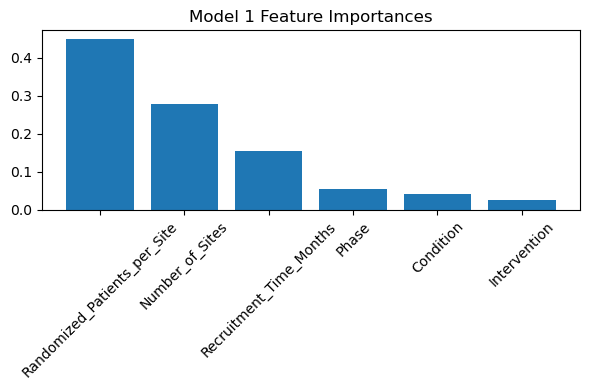

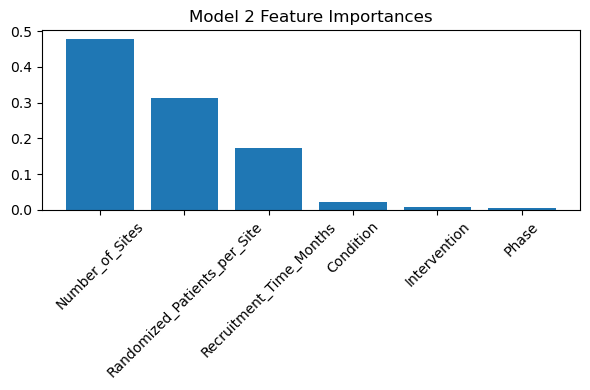

In [44]:
import numpy as np

def plot_feature_importance(model, features, title):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(6, 4))
    plt.title(title)
    plt.bar(range(len(features)), importances[indices], align="center")
    plt.xticks(range(len(features)), [features[i] for i in indices], rotation=45)
    plt.tight_layout()
    plt.show()

plot_feature_importance(model1, features, "Model 1 Feature Importances")
plot_feature_importance(model2, features, "Model 2 Feature Importances")


In [45]:
# Step 10: Print the actual vs predicted RR for both models
print(f"Model 1 (First 7 Pokémon Types) - Performance Metrics")
print(f"MSE: {mse_model1}")
print(f"R2 Score: {r2_model1}")
print(f"MAE: {mae_model1}")
print()

print(f"Model 2 (Next 6 Pokémon Types) - Performance Metrics")
print(f"MSE: {mse_model2}")
print(f"R2 Score: {r2_model2}")
print(f"MAE: {mae_model2}")
print()

Model 1 (First 7 Pokémon Types) - Performance Metrics
MSE: 0.5562114290044959
R2 Score: 0.5993021125241914
MAE: 0.6956467944770343

Model 2 (Next 6 Pokémon Types) - Performance Metrics
MSE: 0.16405653434344503
R2 Score: 0.8157591987581573
MAE: 0.3384128588213263



In [46]:
df['RR'] = df['Number_of_Sites'] * df['Randomized_Patients_per_Site'] * df['Recruitment_Time_Months']
print(df)

    Trial_ID  Condition  Phase    Study_Design  Enrollment   Location  \
0          1          4      0  Non-Randomized         280         UK   
1          2         18      1      Randomized          60    Germany   
2          3          6      2      Randomized         763      Italy   
3          4          8      0      Randomized         744     Canada   
4          5          3      0      Randomized         419    Germany   
..       ...        ...    ...             ...         ...        ...   
95        96          7      2      Randomized         824      Italy   
96        97         18      1  Non-Randomized         612     Brazil   
97        98          2      1      Randomized         190         UK   
98        99          6      1  Non-Randomized         735     Brazil   
99       100          0      2  Non-Randomized         749  Australia   

    Intervention     Outcome_Measure  \
0              0          Tumor Size   
1              9      Infection Rate   
2  

In [47]:
print("Model 1 (First 7 Pokémon Types) - Actual vs Predicted Recruitment Rate")
for actual, pred in zip(y_test1, y_pred1):
    print(f"Actual: {actual:.4f}, Predicted: {pred:.4f}")

print("\nModel 2 (Next 6 Pokémon Types) - Actual vs Predicted Recruitment Rate")
for actual, pred in zip(y_test2, y_pred2):
    print(f"Actual: {actual:.4f}, Predicted: {pred:.4f}")


Model 1 (First 7 Pokémon Types) - Actual vs Predicted Recruitment Rate
Actual: 10.4649, Predicted: 9.5039
Actual: 10.3264, Predicted: 9.4589
Actual: 10.3992, Predicted: 9.9321
Actual: 7.7302, Predicted: 8.6057
Actual: 11.4278, Predicted: 10.7987
Actual: 10.1728, Predicted: 9.3471
Actual: 11.5708, Predicted: 10.7337
Actual: 8.9635, Predicted: 9.0656

Model 2 (Next 6 Pokémon Types) - Actual vs Predicted Recruitment Rate
Actual: 9.1481, Predicted: 8.9152
Actual: 10.0758, Predicted: 10.3244
Actual: 11.4725, Predicted: 10.7517
Actual: 9.9023, Predicted: 10.1998
Actual: 10.6461, Predicted: 10.5122
Actual: 9.0736, Predicted: 9.4456
Actual: 10.7869, Predicted: 10.6143
Actual: 9.2094, Predicted: 9.3919
Actual: 7.8812, Predicted: 8.7519
Actual: 9.5549, Predicted: 9.4170
Actual: 9.1596, Predicted: 9.6090
Actual: 8.3919, Predicted: 8.8264
Actual: 9.5308, Predicted: 9.3848


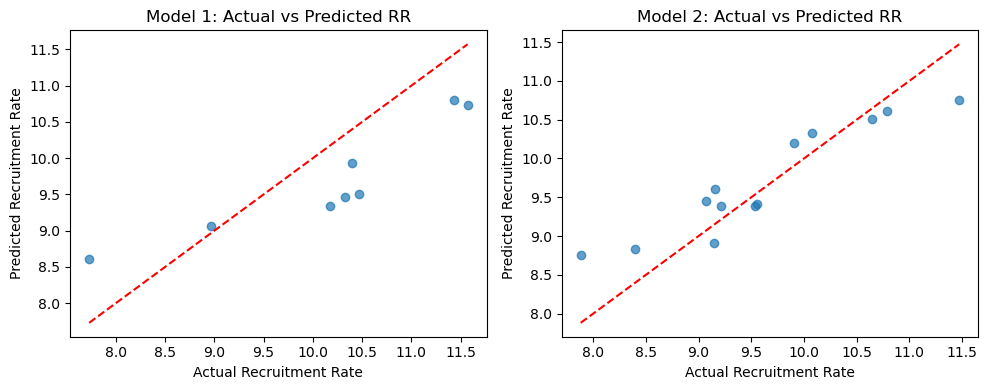

In [48]:
import matplotlib.pyplot as plt

# Model 1 Visualization
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(y_test1, y_pred1, alpha=0.7)
plt.plot([y_test1.min(), y_test1.max()], [y_test1.min(), y_test1.max()], 'r--')
plt.xlabel('Actual Recruitment Rate')
plt.ylabel('Predicted Recruitment Rate')
plt.title('Model 1: Actual vs Predicted RR')

# Model 2 Visualization
plt.subplot(1, 2, 2)
plt.scatter(y_test2, y_pred2, alpha=0.7)
plt.plot([y_test2.min(), y_test2.max()], [y_test2.min(), y_test2.max()], 'r--')
plt.xlabel('Actual Recruitment Rate')
plt.ylabel('Predicted Recruitment Rate')
plt.title('Model 2: Actual vs Predicted RR')

plt.tight_layout()
plt.show()


In [49]:
import numpy as np
import scipy.stats as stats

# ----------- FULL DATASET -------------

pokeclinic_Y = 460
pokeclinic_N = 240
traditional_Y = 310
traditional_N = 390

pokeclinic_total = pokeclinic_Y + pokeclinic_N
traditional_total = traditional_Y + traditional_N
total_Y = pokeclinic_Y + traditional_Y
total_N = pokeclinic_N + traditional_N
total_total = pokeclinic_total + traditional_total

# Recruitment Risk Ratio
rrr_full = (pokeclinic_Y / pokeclinic_total) / (traditional_Y / traditional_total)

# 95% CI
log_rrr = np.log(rrr_full)
se_log_rrr = np.sqrt((1/pokeclinic_Y - 1/pokeclinic_total) + (1/traditional_Y - 1/traditional_total))
ci_lower = np.exp(log_rrr - 1.96 * se_log_rrr)
ci_upper = np.exp(log_rrr + 1.96 * se_log_rrr)

# Chi-square
contingency_full = np.array([[pokeclinic_Y, pokeclinic_N], [traditional_Y, traditional_N]])
chi2_full, p_full, dof_full, expected_full = stats.chi2_contingency(contingency_full)

# ----------- COMPLETERS DATASET -------------

pokeclinic_Y_comp = 320
pokeclinic_N_comp = 210
traditional_Y_comp = 290
traditional_N_comp = 245

pokeclinic_total_comp = pokeclinic_Y_comp + pokeclinic_N_comp
traditional_total_comp = traditional_Y_comp + traditional_N_comp
total_Y_comp = pokeclinic_Y_comp + traditional_Y_comp
total_N_comp = pokeclinic_N_comp + traditional_N_comp
total_total_comp = pokeclinic_total_comp + traditional_total_comp

# Recruitment Risk Ratio
rrr_comp = (pokeclinic_Y_comp / pokeclinic_total_comp) / (traditional_Y_comp / traditional_total_comp)

# 95% CI
log_rrr_comp = np.log(rrr_comp)
se_log_rrr_comp = np.sqrt((1/pokeclinic_Y_comp - 1/pokeclinic_total_comp) + (1/traditional_Y_comp - 1/traditional_total_comp))
ci_lower_comp = np.exp(log_rrr_comp - 1.96 * se_log_rrr_comp)
ci_upper_comp = np.exp(log_rrr_comp + 1.96 * se_log_rrr_comp)

# Chi-square
contingency_comp = np.array([[pokeclinic_Y_comp, pokeclinic_N_comp], [traditional_Y_comp, traditional_N_comp]])
chi2_comp, p_comp, dof_comp, expected_comp = stats.chi2_contingency(contingency_comp)

# ----------- PRINT RESULTS -------------

# Full dataset
print("Results from full dataset (all users)")
print("-" * 60)
print(f"PokeClinic (Gamified)   Y: {pokeclinic_Y}   N: {pokeclinic_N}   Total: {pokeclinic_total}")
print(f"Traditional             Y: {traditional_Y}   N: {traditional_N}   Total: {traditional_total}")
print(f"Total                   Y: {total_Y}   N: {total_N}   Total: {total_total}\n")

print(f"Recruitment Risk Ratio = ({pokeclinic_Y}/{pokeclinic_total})/({traditional_Y}/{traditional_total}) = {rrr_full:.2f}")
print(f"95% CI: {ci_lower:.2f}, {ci_upper:.2f}    Chi-square p {'< 0.001' if p_full < 0.001 else f'= {p_full:.3f}'}\n")

# Completers dataset
print("Results from completers following missing data from a Missing Not at Random comparison")
print("-" * 60)
print(f"PokeClinic (Gamified)   Y: {pokeclinic_Y_comp}   N: {pokeclinic_N_comp}   Total: {pokeclinic_total_comp}")
print(f"Traditional             Y: {traditional_Y_comp}   N: {traditional_N_comp}   Total: {traditional_total_comp}")
print(f"Total                   Y: {total_Y_comp}   N: {total_N_comp}   Total: {total_total_comp}\n")

print(f"Recruitment Risk Ratio = ({pokeclinic_Y_comp}/{pokeclinic_total_comp})/({traditional_Y_comp}/{traditional_total_comp}) = {rrr_comp:.2f}")
print(f"95% CI: {ci_lower_comp:.2f}, {ci_upper_comp:.2f}    Chi-square p {'< 0.001' if p_comp < 0.001 else f'= {p_comp:.3f}'}")


Results from full dataset (all users)
------------------------------------------------------------
PokeClinic (Gamified)   Y: 460   N: 240   Total: 700
Traditional             Y: 310   N: 390   Total: 700
Total                   Y: 770   N: 630   Total: 1400

Recruitment Risk Ratio = (460/700)/(310/700) = 1.48
95% CI: 1.34, 1.64    Chi-square p < 0.001

Results from completers following missing data from a Missing Not at Random comparison
------------------------------------------------------------
PokeClinic (Gamified)   Y: 320   N: 210   Total: 530
Traditional             Y: 290   N: 245   Total: 535
Total                   Y: 610   N: 455   Total: 1065

Recruitment Risk Ratio = (320/530)/(290/535) = 1.11
95% CI: 1.00, 1.24    Chi-square p = 0.048
